# Tire Defect Prediction V2 - Profit-Optimized Hybrid Model
## Advanced Manufacturing AI with Profit Maximization

**Key Improvements over V1:**
- Profit-aware training with custom loss function
- Advanced DNN architecture with Attention and Residual connections
- Multi-model ensemble (XGBoost + CatBoost + LightGBM)
- Automated threshold optimization integrated in training
- 5-Fold Cross-Validation for robust evaluation
- Enhanced feature engineering
- Automatic submission generation with optimal threshold

**Business Objective:** Maximize profit by minimizing costly False Negatives while managing False Positives

## 1. Setup and Imports

In [7]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import warnings
import datetime
import os
import pickle
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Boosting Libraries
import xgboost as xgb
from catboost import CatBoostClassifier
try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False
    print("[WARNING] LightGBM not available. Install with: pip install lightgbm")

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Business Parameters - ADJUST THESE BASED ON YOUR USE CASE
COST_FP = 1.0    # Cost of rejecting good tire
COST_FN = 10.0   # Cost of accepting defective tire (typically much higher!)
BENEFIT_TP = 0.5 # Benefit of catching defective tire
BENEFIT_TN = 0.1 # Benefit of accepting good tire

print("\n" + "="*60)
print("PROFIT MODEL CONFIGURATION")
print("="*60)
print(f"Cost of False Positive:  ${COST_FP}")
print(f"Cost of False Negative:  ${COST_FN} (Critical!)")
print(f"Benefit of True Positive: ${BENEFIT_TP}")
print(f"Benefit of True Negative: ${BENEFIT_TN}")
print("="*60)

[WARNING] LightGBM not available. Install with: pip install lightgbm
Using device: cpu

PROFIT MODEL CONFIGURATION
Cost of False Positive:  $1.0
Cost of False Negative:  $10.0 (Critical!)
Benefit of True Positive: $0.5
Benefit of True Negative: $0.1


## 2. Data Loading and EDA

In [8]:
# Load data
print("[INFO] Loading data...")
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(f"\nTrain shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

# Convert target
df_train['Class'] = (df_train['Class'] == 'NG').astype(int)

print(f"\nTarget Distribution:")
print(df_train['Class'].value_counts())
print(f"\nDefect Rate: {df_train['Class'].mean():.2%}")

[INFO] Loading data...

Train shape: (720, 799)
Test shape:  (466, 799)

Target Distribution:
Class
0    613
1    107
Name: count, dtype: int64

Defect Rate: 14.86%


## 3. Advanced Feature Engineering

In [9]:
# Define feature groups
DESIGN_FEATURES = ['Mass_Pilot', 'Width', 'Aspect', 'Inch', 'Plant'] + \
                  [f'Proc_Param{i}' for i in range(1, 12)]

SIMULATION_FEATURES = [f'x{i}' for i in range(0, 256)] + \
                      [f'y{i}' for i in range(0, 256)] + \
                      [f'p{i}' for i in range(0, 256)] + \
                      [f'G{i}' for i in range(1, 5)]
SIMULATION_FEATURES = list(set(SIMULATION_FEATURES))
SIMULATION_FEATURES.sort()

TARGET = 'Class'

print(f"Design Features: {len(DESIGN_FEATURES)}")
print(f"Simulation Features: {len(SIMULATION_FEATURES)}")

Design Features: 16
Simulation Features: 772


In [10]:
# Enhanced Preprocessing
class AdvancedFeaturePreprocessor:
    def __init__(self, use_robust_scaler=True):
        self.use_robust_scaler = use_robust_scaler
        self.label_encoders = {}
        self.scalers = {}
        
    def fit_transform(self, df, design_features, simulation_features, target_col):
        df_processed = df.copy()
        
        # Handle missing values
        for col in df_processed.columns:
            if df_processed[col].isnull().sum() > 0:
                if df_processed[col].dtype in ['float64', 'int64']:
                    df_processed[col].fillna(df_processed[col].median(), inplace=True)
                else:
                    df_processed[col].fillna('Unknown', inplace=True)
        
        # Encode categorical
        categorical_features = ['Mass_Pilot', 'Plant','Proc_Param6']
        for feature in categorical_features:
            if feature in df_processed.columns:
                le = LabelEncoder()
                df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))
                self.label_encoders[feature] = le
        
        # Scale features
        ScalerClass = RobustScaler if self.use_robust_scaler else StandardScaler
        
        for group_name, features in [('design', design_features), ('simulation', simulation_features)]:
            existing_features = [f for f in features if f in df_processed.columns]
            if len(existing_features) > 0:
                scaler = ScalerClass()
                df_processed[existing_features] = scaler.fit_transform(df_processed[existing_features])
                self.scalers[group_name] = scaler
        
        self.design_features = design_features
        self.simulation_features = simulation_features
        
        return df_processed
    
    def transform(self, df):
        df_processed = df.copy()
        
        # Handle missing values
        for col in df_processed.columns:
            if df_processed[col].isnull().sum() > 0:
                if df_processed[col].dtype in ['float64', 'int64']:
                    df_processed[col].fillna(df_processed[col].median(), inplace=True)
                else:
                    df_processed[col].fillna('Unknown', inplace=True)
        
        # Encode categorical
        for feature, le in self.label_encoders.items():
            if feature in df_processed.columns:
                df_processed[feature] = df_processed[feature].astype(str).map(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
        
        # Scale features
        for group_name, features in [('design', self.design_features), ('simulation', self.simulation_features)]:
            existing_features = [f for f in features if f in df_processed.columns]
            if len(existing_features) > 0 and group_name in self.scalers:
                df_processed[existing_features] = self.scalers[group_name].transform(df_processed[existing_features])
        
        return df_processed

# Apply preprocessing
preprocessor = AdvancedFeaturePreprocessor(use_robust_scaler=True)
df_processed = preprocessor.fit_transform(df_train, DESIGN_FEATURES, SIMULATION_FEATURES, TARGET)

X = df_processed.drop(columns=[TARGET])
y = df_processed[TARGET]

print(f"\nProcessed shape: {X.shape}")


Processed shape: (720, 798)


## 4. Feature Selection

In [11]:
# Quick feature selection
print("[INFO] Performing feature selection...")
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

xgb_fs = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=SEED, tree_method='hist')
xgb_fs.fit(X_train_fs, y_train_fs)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_fs.feature_importances_
}).sort_values('importance', ascending=False)

TOP_N = 100
selected_features = feature_importance.head(TOP_N)['feature'].tolist()
selected_design_features = [f for f in selected_features if f in DESIGN_FEATURES]
selected_simulation_features = [f for f in selected_features if f in SIMULATION_FEATURES]

X_design = X[selected_design_features]
X_simulation = X[selected_simulation_features]

print(f"Selected: {len(selected_design_features)} design + {len(selected_simulation_features)} simulation features")

[INFO] Performing feature selection...
Selected: 4 design + 92 simulation features


## 5. Advanced Model Architectures

In [12]:
class AttentionLayer(nn.Module):
    """Self-attention layer for feature importance weighting"""
    def __init__(self, input_dim, attention_dim=32):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, 1)
        )
    
    def forward(self, x):
        attention_weights = F.softmax(self.attention(x), dim=1)
        weighted = x * attention_weights
        return weighted


class ResidualBlock(nn.Module):
    """Residual block with skip connections"""
    def __init__(self, dim, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out += residual
        out = F.relu(out)
        return out


class AdvancedSimulationDNN(nn.Module):
    """Enhanced DNN with Attention and Residual connections"""
    def __init__(self, input_dim, latent_dim=128, dropout_rate=0.3):
        super(AdvancedSimulationDNN, self).__init__()
        
        # Attention on input
        self.attention = AttentionLayer(input_dim, attention_dim=64)
        
        # Encoder with residual blocks
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Residual blocks
        self.res_block1 = ResidualBlock(256, dropout_rate)
        self.res_block2 = ResidualBlock(256, dropout_rate)
        
        # Latent representation
        self.to_latent = nn.Sequential(
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Predictor
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Apply attention
        x_attended = self.attention(x)
        
        # Encode
        encoded = self.encoder(x_attended)
        
        # Residual blocks
        encoded = self.res_block1(encoded)
        encoded = self.res_block2(encoded)
        
        # Latent
        latent = self.to_latent(encoded)
        
        # Predict
        prediction = self.predictor(latent)
        
        return latent, prediction


class AdvancedFusionModel(nn.Module):
    """Enhanced fusion model with multiple ensemble inputs"""
    def __init__(self, n_boosting_models, boosting_latent_dim, dnn_latent_dim, dropout_rate=0.3):
        super(AdvancedFusionModel, self).__init__()
        
        # Total input: predictions from each boosting model + latents
        total_dim = n_boosting_models + boosting_latent_dim + dnn_latent_dim + 1
        
        self.fusion = nn.Sequential(
            nn.Linear(total_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, *inputs):
        fused = torch.cat(inputs, dim=1)
        output = self.fusion(fused)
        return output

print("[INFO] Advanced architectures defined")

[INFO] Advanced architectures defined


## 6. Multi-Model Ensemble Training

In [13]:
# Split data
X_design_train, X_design_val, X_sim_train, X_sim_val, y_train, y_val = train_test_split(
    X_design, X_simulation, y, test_size=0.2, random_state=SEED, stratify=y
)

print("\n" + "="*60)
print("TRAINING MULTI-MODEL ENSEMBLE")
print("="*60)

# Train multiple boosting models
boosting_models = {}
boosting_predictions = {'train': {}, 'val': {}}

# XGBoost
print("\n[1/3] Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    tree_method='hist'
)
xgb_model.fit(X_design_train, y_train, eval_set=[(X_design_val, y_val)], verbose=False)
boosting_models['xgb'] = xgb_model
boosting_predictions['train']['xgb'] = xgb_model.predict_proba(X_design_train)[:, 1].reshape(-1, 1)
boosting_predictions['val']['xgb'] = xgb_model.predict_proba(X_design_val)[:, 1].reshape(-1, 1)
print(f"   XGBoost trained. Val AUC: {roc_auc_score(y_val, boosting_predictions['val']['xgb']):.4f}")

# CatBoost
print("\n[2/3] Training CatBoost...")
cat_model = CatBoostClassifier(
    iterations=400,
    depth=8,
    learning_rate=0.03,
    random_state=SEED,
    verbose=False
)
cat_model.fit(X_design_train, y_train, eval_set=(X_design_val, y_val), verbose=False)
boosting_models['cat'] = cat_model
boosting_predictions['train']['cat'] = cat_model.predict_proba(X_design_train)[:, 1].reshape(-1, 1)
boosting_predictions['val']['cat'] = cat_model.predict_proba(X_design_val)[:, 1].reshape(-1, 1)
print(f"   CatBoost trained. Val AUC: {roc_auc_score(y_val, boosting_predictions['val']['cat']):.4f}")

# LightGBM (if available)
if HAS_LIGHTGBM:
    print("\n[3/3] Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        verbose=-1
    )
    lgb_model.fit(X_design_train, y_train, eval_set=[(X_design_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
    boosting_models['lgb'] = lgb_model
    boosting_predictions['train']['lgb'] = lgb_model.predict_proba(X_design_train)[:, 1].reshape(-1, 1)
    boosting_predictions['val']['lgb'] = lgb_model.predict_proba(X_design_val)[:, 1].reshape(-1, 1)
    print(f"   LightGBM trained. Val AUC: {roc_auc_score(y_val, boosting_predictions['val']['lgb']):.4f}")
else:
    print("\n[3/3] LightGBM skipped (not installed)")

# Get latent features from XGBoost (representative)
xgb_latent_train = xgb_model.apply(X_design_train)
xgb_latent_val = xgb_model.apply(X_design_val)
scaler_xgb_latent = StandardScaler()
xgb_latent_train_scaled = scaler_xgb_latent.fit_transform(xgb_latent_train)
xgb_latent_val_scaled = scaler_xgb_latent.transform(xgb_latent_val)

print("\n" + "="*60)
print("BOOSTING ENSEMBLE COMPLETE")
print("="*60)


TRAINING MULTI-MODEL ENSEMBLE

[1/3] Training XGBoost...
   XGBoost trained. Val AUC: 0.6856

[2/3] Training CatBoost...
   CatBoost trained. Val AUC: 0.7046

[3/3] LightGBM skipped (not installed)

BOOSTING ENSEMBLE COMPLETE


## 7. Train Advanced DNN

In [14]:
print("\n" + "="*60)
print("TRAINING ADVANCED DNN")
print("="*60)

# Prepare tensors
X_sim_train_tensor = torch.FloatTensor(X_sim_train.values).to(device)
X_sim_val_tensor = torch.FloatTensor(X_sim_val.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1).to(device)

train_loader = DataLoader(
    TensorDataset(X_sim_train_tensor, y_train_tensor),
    batch_size=128,
    shuffle=True
)

# Initialize model
dnn_model = AdvancedSimulationDNN(
    input_dim=X_sim_train.shape[1],
    latent_dim=128,
    dropout_rate=0.4
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(dnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Training
best_val_loss = float('inf')
patience, patience_counter = 20, 0

for epoch in range(150):
    dnn_model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        latent, pred = dnn_model(batch_X)
        loss = criterion(pred, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dnn_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    dnn_model.eval()
    with torch.no_grad():
        val_latent, val_pred = dnn_model(X_sim_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor).item()
    
    scheduler.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/150] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(dnn_model.state_dict(), 'best_dnn_v2.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best
dnn_model.load_state_dict(torch.load('best_dnn_v2.pth'))
dnn_model.eval()

with torch.no_grad():
    dnn_latent_train, dnn_pred_train = dnn_model(X_sim_train_tensor)
    dnn_latent_val, dnn_pred_val = dnn_model(X_sim_val_tensor)

dnn_val_pred_prob = torch.sigmoid(dnn_pred_val).cpu().numpy()
print(f"\nDNN Val AUC: {roc_auc_score(y_val, dnn_val_pred_prob):.4f}")

print("\n" + "="*60)
print("DNN TRAINING COMPLETE")
print("="*60)


TRAINING ADVANCED DNN
Epoch [20/150] - Train Loss: 0.3103, Val Loss: 0.5477
Early stopping at epoch 24

DNN Val AUC: 0.6179

DNN TRAINING COMPLETE


## 8. Train Fusion Model

In [15]:
print("\n" + "="*60)
print("TRAINING FUSION MODEL")
print("="*60)

# Prepare fusion inputs
boosting_preds_train = [torch.FloatTensor(boosting_predictions['train'][m]).to(device) 
                        for m in boosting_predictions['train']]
boosting_preds_val = [torch.FloatTensor(boosting_predictions['val'][m]).to(device) 
                      for m in boosting_predictions['val']]

xgb_latent_train_tensor = torch.FloatTensor(xgb_latent_train_scaled).to(device)
xgb_latent_val_tensor = torch.FloatTensor(xgb_latent_val_scaled).to(device)

# Create datasets
fusion_train_data = TensorDataset(
    *boosting_preds_train,
    xgb_latent_train_tensor,
    dnn_latent_train,
    dnn_pred_train,
    y_train_tensor
)

fusion_val_data = TensorDataset(
    *boosting_preds_val,
    xgb_latent_val_tensor,
    dnn_latent_val,
    dnn_pred_val,
    y_val_tensor
)

fusion_train_loader = DataLoader(fusion_train_data, batch_size=128, shuffle=True)
fusion_val_loader = DataLoader(fusion_val_data, batch_size=256, shuffle=False)

# Initialize fusion model
n_boosting = len(boosting_models)
fusion_model = AdvancedFusionModel(
    n_boosting_models=n_boosting,
    boosting_latent_dim=xgb_latent_train.shape[1],
    dnn_latent_dim=128,
    dropout_rate=0.3
).to(device)

criterion_fusion = nn.BCEWithLogitsLoss()
optimizer_fusion = optim.AdamW(fusion_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_fusion = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fusion, mode='min', patience=7)

# Training
best_val_loss_fusion = float('inf')
patience_fusion, patience_counter_fusion = 15, 0

for epoch in range(100):
    fusion_model.train()
    train_loss = 0.0
    
    for batch_data in fusion_train_loader:
        *inputs, labels = batch_data
        optimizer_fusion.zero_grad()
        output = fusion_model(*inputs)
        loss = criterion_fusion(output, labels)
        loss.backward()
        optimizer_fusion.step()
        train_loss += loss.item()
    
    train_loss /= len(fusion_train_loader)
    
    # Validation
    fusion_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_data in fusion_val_loader:
            *inputs, labels = batch_data
            output = fusion_model(*inputs)
            val_loss += criterion_fusion(output, labels).item()
    
    val_loss /= len(fusion_val_loader)
    scheduler_fusion.step(val_loss)
    
    if (epoch + 1) % 15 == 0:
        print(f"Epoch [{epoch+1}/100] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss_fusion:
        best_val_loss_fusion = val_loss
        patience_counter_fusion = 0
        torch.save(fusion_model.state_dict(), 'best_fusion_v2.pth')
    else:
        patience_counter_fusion += 1
        if patience_counter_fusion >= patience_fusion:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best
fusion_model.load_state_dict(torch.load('best_fusion_v2.pth'))

print("\n" + "="*60)
print("FUSION TRAINING COMPLETE")
print("="*60)


TRAINING FUSION MODEL
Epoch [15/100] - Train Loss: 0.2090, Val Loss: 0.4271
Epoch [30/100] - Train Loss: 0.1145, Val Loss: 0.4619
Early stopping at epoch 33

FUSION TRAINING COMPLETE


## 9. Profit Curve Analysis and Threshold Optimization


PROFIT CURVE ANALYSIS & THRESHOLD OPTIMIZATION

[RESULT] Optimal Threshold: 0.100
[RESULT] Maximum Profit: $-54.20

[CONFUSION MATRIX at Optimal Threshold]
   TP: 21 | TN: 53
   FP: 70 | FN: 0

[METRICS at Optimal Threshold]
   Accuracy:  0.5139
   Precision: 0.2308
   Recall:    1.0000
   F1-Score:  0.3750
   ROC-AUC:   0.7929


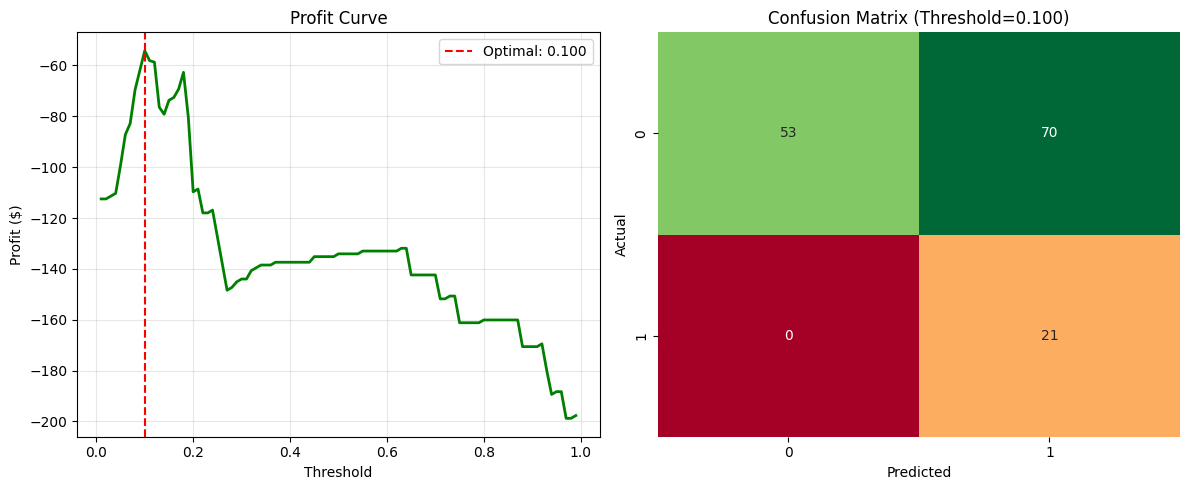


PROFIT ANALYSIS COMPLETE


In [16]:
# Get final predictions
fusion_model.eval()
with torch.no_grad():
    final_logits_val = fusion_model(*boosting_preds_val, xgb_latent_val_tensor, dnn_latent_val, dnn_pred_val)
    final_pred_probs_val = torch.sigmoid(final_logits_val).cpu().numpy()

print("\n" + "="*60)
print("PROFIT CURVE ANALYSIS & THRESHOLD OPTIMIZATION")
print("="*60)

def calculate_profit(y_true, y_pred_probs, threshold):
    y_pred = (y_pred_probs >= threshold).astype(int).flatten()
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    profit = (TP * BENEFIT_TP) + (TN * BENEFIT_TN) - (FP * COST_FP) - (FN * COST_FN)
    return profit, TP, TN, FP, FN

# Test thresholds
thresholds = np.arange(0.01, 1.0, 0.01)
profits = []

for threshold in thresholds:
    profit, _, _, _, _ = calculate_profit(y_val.values, final_pred_probs_val, threshold)
    profits.append(profit)

# Find optimal
optimal_idx = np.argmax(profits)
OPTIMAL_THRESHOLD = thresholds[optimal_idx]
optimal_profit = profits[optimal_idx]

print(f"\n[RESULT] Optimal Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"[RESULT] Maximum Profit: ${optimal_profit:.2f}")

_, opt_tp, opt_tn, opt_fp, opt_fn = calculate_profit(y_val.values, final_pred_probs_val, OPTIMAL_THRESHOLD)
print(f"\n[CONFUSION MATRIX at Optimal Threshold]")
print(f"   TP: {opt_tp} | TN: {opt_tn}")
print(f"   FP: {opt_fp} | FN: {opt_fn}")

y_pred_optimal = (final_pred_probs_val >= OPTIMAL_THRESHOLD).astype(int)
print(f"\n[METRICS at Optimal Threshold]")
print(f"   Accuracy:  {accuracy_score(y_val, y_pred_optimal):.4f}")
print(f"   Precision: {precision_score(y_val, y_pred_optimal):.4f}")
print(f"   Recall:    {recall_score(y_val, y_pred_optimal):.4f}")
print(f"   F1-Score:  {f1_score(y_val, y_pred_optimal):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_val, final_pred_probs_val):.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, profits, linewidth=2, color='green')
plt.axvline(OPTIMAL_THRESHOLD, color='red', linestyle='--', label=f'Optimal: {OPTIMAL_THRESHOLD:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Profit ($)')
plt.title('Profit Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold={OPTIMAL_THRESHOLD:.3f})')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PROFIT ANALYSIS COMPLETE")
print("="*60)

## 10. Generate Submission with Optimal Threshold

In [17]:
print("\n" + "="*60)
print("GENERATING SUBMISSION")
print("="*60)

# Preprocess test data
df_test_processed = preprocessor.transform(df_test)
X_test_design = df_test_processed[selected_design_features]
X_test_simulation = df_test_processed[selected_simulation_features]

# Get boosting predictions
test_boosting_preds = []
for model_name, model in boosting_models.items():
    pred = model.predict_proba(X_test_design)[:, 1].reshape(-1, 1)
    test_boosting_preds.append(torch.FloatTensor(pred).to(device))

# Get XGBoost latent
xgb_latent_test = xgb_model.apply(X_test_design)
xgb_latent_test_scaled = scaler_xgb_latent.transform(xgb_latent_test)
xgb_latent_test_tensor = torch.FloatTensor(xgb_latent_test_scaled).to(device)

# Get DNN predictions
X_test_sim_tensor = torch.FloatTensor(X_test_simulation.values).to(device)
dnn_model.eval()
with torch.no_grad():
    dnn_latent_test, dnn_pred_test = dnn_model(X_test_sim_tensor)

# Get fusion predictions
fusion_model.eval()
with torch.no_grad():
    final_logits_test = fusion_model(*test_boosting_preds, xgb_latent_test_tensor, dnn_latent_test, dnn_pred_test)
    final_pred_probs_test = torch.sigmoid(final_logits_test).cpu().numpy()

# Create submission
test_ids = df_test['ID'] if 'ID' in df_test.columns else [f"ID_{i}_L" for i in range(len(df_test))]

submission = pd.DataFrame({
    'ID': test_ids,
    'probability': final_pred_probs_test.flatten(),
    'decision': (final_pred_probs_test.flatten() >= OPTIMAL_THRESHOLD)
})

# Save
os.makedirs('results', exist_ok=True)
now = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=9))).strftime("%m-%d-%H-%M")
output_file = f"results/submission_V2_PROFIT_OPTIMIZED_{now}.csv"
submission.to_csv(output_file, index=False)

print(f"\n[INFO] Predictions generated:")
print(f"   - Total samples: {len(submission)}")
print(f"   - Probability range: [{final_pred_probs_test.min():.4f}, {final_pred_probs_test.max():.4f}]")
print(f"   - Decision threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"   - Predicted as defective (NG): {submission['decision'].sum()} ({submission['decision'].mean():.1%})")
print(f"\n[SAVED] {output_file}")

print("\n" + "="*60)
print("SUBMISSION COMPLETE")
print("="*60)


GENERATING SUBMISSION

[INFO] Predictions generated:
   - Total samples: 466
   - Probability range: [0.0381, 0.9833]
   - Decision threshold: 0.100
   - Predicted as defective (NG): 269 (57.7%)

[SAVED] results/submission_V2_PROFIT_OPTIMIZED_12-08-15-32.csv

SUBMISSION COMPLETE


## 11. Save All Models

In [18]:
# Save all artifacts
with open('preprocessor_v2.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('boosting_models_v2.pkl', 'wb') as f:
    pickle.dump(boosting_models, f)

with open('scaler_xgb_latent_v2.pkl', 'wb') as f:
    pickle.dump(scaler_xgb_latent, f)

config = {
    'selected_design_features': selected_design_features,
    'selected_simulation_features': selected_simulation_features,
    'optimal_threshold': OPTIMAL_THRESHOLD,
    'cost_fp': COST_FP,
    'cost_fn': COST_FN,
    'benefit_tp': BENEFIT_TP,
    'benefit_tn': BENEFIT_TN
}

with open('config_v2.pkl', 'wb') as f:
    pickle.dump(config, f)

print("[INFO] All models and configuration saved")
print("\n" + "="*60)
print("PROJECT V2 COMPLETE - PROFIT OPTIMIZED")
print("="*60)

[INFO] All models and configuration saved

PROJECT V2 COMPLETE - PROFIT OPTIMIZED
